# Оглавление:

* [Описание проекта](#b1)
* [1. Импорт данных](#b2)
* [2. Проверка данных](#b3)
* [3. Подготовка данных](#b4)
* [4. Анализ данных](#b5)
* [5. Проверка гипотез](#b6)
* [Вывод](#b7)

# Описание проекта <a class="anchor" id="b1"></a>

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.


В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Необходимо:
* сделать предварительный анализ тарифов на небольшой выборке клиентов - какие объемы услуг используют пользователи каждого тарифа, какой доход получает компания;  
* проверить гипотезы:
    * средние выручки пользователей тарифов «Ультра» и «Смарт» различаются;
    * средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Описание тарифов
Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

### Примечание

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

В данных есть звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

### Описание данных

Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# 1. Импорт данных <a class="anchor" id="b2"></a>

In [2]:
users = pd.read_csv('data/users.csv')
tariffs = pd.read_csv('data/tariffs.csv')
calls = pd.read_csv('data/calls.csv')
messages = pd.read_csv('data/messages.csv')
internet = pd.read_csv('data/internet.csv')

# 2. Проверка данных <a class="anchor" id="b3"></a>

## Users

In [3]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Приведем столбцы reg_date и churn_date к типу datetime, а также избавимся от столбцов first_name и last_name, так как эти данные выглядят излишними

In [4]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users = users.drop(['first_name', 'last_name'], axis=1)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   reg_date    500 non-null    datetime64[ns]
 5   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 23.6+ KB


Проверим данные на наличие явных ошибок. 


Данные должны быть за 2018 год, проверим это

In [5]:
users.describe()
for column_name in ['churn_date','reg_date']:
    column = users[column_name]
    print(f'{column_name}: \tmin: {column.min()}, \tmax: {column.max()}')

churn_date: 	min: 2018-08-17 00:00:00, 	max: 2018-12-30 00:00:00
reg_date: 	min: 2018-01-01 00:00:00, 	max: 2018-12-31 00:00:00


Даты корректны. Поcтроим гистограмму распределения возрастов.

Text(0, 0.5, 'Количество')

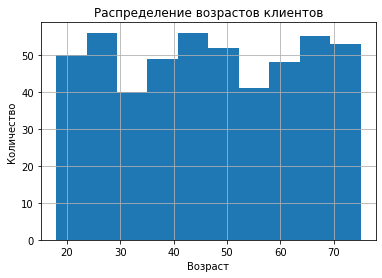

In [6]:
users['age'].hist(bins = 10)
plt.title('Распределение возрастов клиентов')
plt.xlabel('Возраст')
plt.ylabel('Количество')

Здесь также нет явных ошибок, также отметим, что все возрасты представлены достаточно равномерно.

Убедимся, что все рассматриваемые пользователи используют только исследуемые тарифы - «Смарт» и «Ультра»

In [7]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

Все верно. Сразу взглянем, какие города представлены

In [8]:
print(len(users['city'].unique()))
users['city'].unique()

76


array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

### Tariffs

Для таблицы tariffs достаточно проверить, что хранящиеся там данные соответствуют условию, и типы данных подобраны корректно.

In [9]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Все верно. 

### Сalls

In [10]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Приведем столбец id к типу int, call_date -- к типу datetime и проверим, что все данные относятся к 2018 году

In [11]:
calls['id'] = calls['id'].astype(int)
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")
print(f"min: {calls['call_date'].min()}, max: {calls['call_date'].max()}")

min: 2018-01-01 00:00:00, max: 2018-12-31 00:00:00


Все верно. Следуя правилам компании, округлим длительность звонка до минут (в большую сторону), приведя соответсвующий столбец к типу int

In [12]:
calls['duration'] = calls['duration'].apply(lambda float_minutes: ceil(float_minutes))
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int32         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 5.4 MB


Теперь проверим адекватность значений длительности звонков. Для этого построим диаграмму размаха.

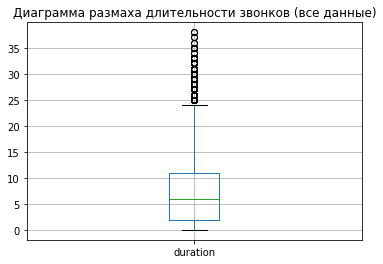

In [13]:
calls.boxplot('duration')
plt.title('Диаграмма размаха длительности звонков (все данные)')
plt.show()

Медиана находитмя на уровне 6 минут, есть звонки по 0 минут (по условию это не ошибка, так отмечены пропущенные звонки, и их удалять нельзя), а также выбивающиеся звонки (более 25 минут). В целом, данные скошены вправо. Проверим, что это не вызвано способом отметки пропцщенных звонков, и заодно определим их количество

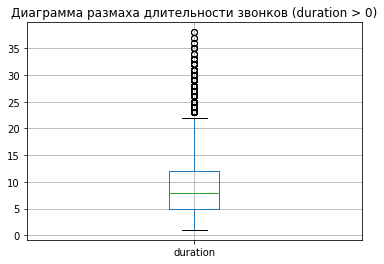

Всего звонков: 202607, пропущенных звонков: 39613 (19.6%)


In [14]:
accepted_calls = calls.query('duration > 0')
accepted_calls.boxplot('duration')
plt.title('Диаграмма размаха длительности звонков (duration > 0)')
plt.show()

all_calls_amount = len(calls)
accepted_calls_amount = len(accepted_calls)
missed_calls_amount = all_calls_amount - accepted_calls_amount
print(f'Всего звонков: {all_calls_amount}, пропущенных звонков: {missed_calls_amount} ({round(missed_calls_amount * 100 / all_calls_amount, 1)}%)')

Около 20% всех звонков - пропущенные, однако на распределение данных это оказывает не большое влияние. Видимо, короткие звонки (около минуты) -- вполне частое явление для рассматриваемых клиентов

### Messages

In [15]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Приведем столбец id к типу int, message_date -- к типу datetime и проверим, что данные относятся к необходимому периоду

In [16]:
messages['id'] = messages['id'].astype(int)
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")
print(f"min: {messages['message_date'].min()}, max: {messages['message_date'].max()}")

min: 2018-01-02 00:00:00, max: 2018-12-31 00:00:00


Все корректно.

### Internet

In [17]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Сразу избавимся от дублирующего индекс столбца `Unnamed: 0`. Также приведем столбец id к типу int, session_date -- к типу datetime и проверим, что данные относятся к необходимому периоду

In [18]:
internet = internet.drop(['Unnamed: 0'], axis=1)
internet['id'] = internet['id'].astype(int)
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")
print(f"min: {internet['session_date'].min()}, max: {internet['session_date'].max()}")

min: 2018-01-01 00:00:00, max: 2018-12-31 00:00:00


Все корректно. Следуя правилам компании, округлять mb_used до Мб каждой отдельной сессии не нужно, они округляются в сумме за месяц.

Теперь проверим адекватность значений использованных мегабайт. Для этого построим диаграмму размаха.

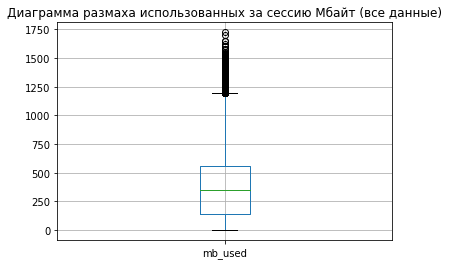

In [19]:
plt.title('Диаграмма размаха использованных за сессию Мбайт (все данные)')
internet.boxplot('mb_used')
plt.show()

В данных есть сессии, где использовано 0 Мбайт. Это выглядит подозрительно. Посмотрим долю таких записей

In [20]:
print(len(internet.query('mb_used == 0')) / len(internet))

0.13118155773916304


Довольно много -- около 13%. Такие значения могли появиться в результате сбоев при сборе данных или если не удалось подключиться к интернету. Они могут серьезно перетягивают статистику, проверим это.

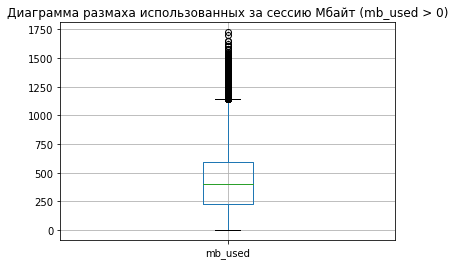

In [21]:
plt.title('Диаграмма размаха использованных за сессию Мбайт (mb_used > 0)')
internet.query('mb_used > 0').boxplot('mb_used')
plt.show()

Структурные характеристики сместились не сильно (например, медиана -- примерно с 350 до 400), однако сессии, где было импользовано 0 Мбайт не предоставляют нам информации для решения задачи, заменить их на среднее тоже некорректно, поэтому избавимся от таких записей.

In [22]:
internet = internet.query('mb_used > 0')

### Общее

Все таблицы просмотрены и проведен первичный анализ. Пропуски есть только в столбце churn_date таблицы users (в обработке не нуждаются, так как это значит, что тариф все еще действовал). Проверим еще один момент -- во всех таблицах, которые ссылаются на пользователя по его id, проверим, что пользователь с таким id представлен в таблице users

In [23]:
all_user_ids = set(users['user_id'])

messages_user_ids = set(messages['user_id'])
if messages_user_ids.difference(all_user_ids):
    print('Ошибка в messages')
    
calls_user_ids = set(calls['user_id'])
if calls_user_ids.difference(all_user_ids):
    print('Ошибка в calls')
    
internet_user_ids = set(internet['user_id'])
if internet_user_ids.difference(all_user_ids):
    print('Ошибка в internet')

Ошибок нет

# 3. Подготовка данных <a class="anchor" id="b4"></a>

Для определения того, какой тариф приносит больше денег (на данной выборке), необходимо подсчитать некоторые данные. Для каждого пользователя найдем:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам (окргуляем до гигабайт в большую сторону по правилам компании).

Объединим этм данные в одну таблицу. Чтобы собрать все данные, join выполним по принципу outer, и тогда пустые значения будут значить, что пользователь пользовался тарифом в этом месяце, но не использовал соответствующую услугу, поэтому их заполним  нулями.

In [24]:
calls['month'] = calls['call_date'].dt.month
calls_stats = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
calls_stats.columns = ['calls_minutes', 'calls_amount']

internet['month'] = internet['session_date'].dt.month
internet_stats = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_stats['gb_used'] = internet_stats['mb_used'].apply(lambda mb: ceil(mb / 1024))
internet_stats = internet_stats.drop(['mb_used'], axis=1)

messages['month'] = messages['message_date'].dt.month
messages_stats = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
messages_stats.columns = ['messages_amount']

users_stats = calls_stats.join(internet_stats, how='outer').join(messages_stats, how='outer')
users_stats = users_stats.reset_index()
users_stats = users_stats.sort_values(by=['user_id', 'month'])
users_stats = users_stats.fillna(0)
users_stats = users_stats.merge(users[['tariff', 'age', 'city', 'user_id']], how = 'left')
for column_name in ['calls_minutes', 'calls_amount', 'gb_used', 'messages_amount']:
    users_stats[column_name] = users_stats[column_name].astype(int)

    
users_stats.info()
users_stats.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          3214 non-null   int64 
 1   month            3214 non-null   int64 
 2   calls_minutes    3214 non-null   int32 
 3   calls_amount     3214 non-null   int32 
 4   gb_used          3214 non-null   int32 
 5   messages_amount  3214 non-null   int32 
 6   tariff           3214 non-null   object
 7   age              3214 non-null   int64 
 8   city             3214 non-null   object
dtypes: int32(4), int64(3), object(2)
memory usage: 200.9+ KB


,user_id,month,calls_minutes,calls_amount,gb_used,messages_amount,tariff,age,city
0,1000,5,159,22,3,22,ultra,52,Краснодар
1,1000,6,172,43,23,60,ultra,52,Краснодар
2,1000,7,340,47,14,75,ultra,52,Краснодар
3,1000,8,408,52,14,81,ultra,52,Краснодар
4,1000,9,466,58,15,57,ultra,52,Краснодар
5,1000,10,350,57,15,73,ultra,52,Краснодар
6,1000,11,338,43,15,58,ultra,52,Краснодар
7,1000,12,333,46,10,70,ultra,52,Краснодар
8,1001,11,430,59,18,0,smart,41,Москва
9,1001,12,414,63,14,0,smart,41,Москва


Теперь рассчитаем помесячную выручку с каждого пользователя: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остатки умножим на соответсвующие значения из тарифного плана и, наконец, прибавим абонентскую плату, соответствующую тарифному плану.

In [25]:
tariffs_dict = tariffs.set_index('tariff_name').to_dict(orient='index')
tariffs_dict

{'smart': {'messages_included': 50,
  'mb_per_month_included': 15360,
  'minutes_included': 500,
  'rub_monthly_fee': 550,
  'rub_per_gb': 200,
  'rub_per_message': 3,
  'rub_per_minute': 3},
 'ultra': {'messages_included': 1000,
  'mb_per_month_included': 30720,
  'minutes_included': 3000,
  'rub_monthly_fee': 1950,
  'rub_per_gb': 150,
  'rub_per_message': 1,
  'rub_per_minute': 1}}

In [26]:
def count_revenue(um_info):
    tariff_info = tariffs_dict[um_info['tariff']]
    
    revenue = tariff_info['rub_monthly_fee']
    
    revenue += (max(um_info['calls_minutes'] - tariff_info['minutes_included'], 0) * 
                tariff_info['rub_per_minute'])
    
    revenue += (max(um_info['gb_used'] - tariff_info['mb_per_month_included'] // 1024, 0) * 
                tariff_info['rub_per_gb'])
    
    revenue += (max(um_info['messages_amount'] - tariff_info['messages_included'], 0) * 
                tariff_info['rub_per_message'])

    return(revenue)



users_stats['revenue'] = users_stats.apply(count_revenue, axis = 1)  
users_stats.head(20)

,user_id,month,calls_minutes,calls_amount,gb_used,messages_amount,tariff,age,city,revenue
0,1000,5,159,22,3,22,ultra,52,Краснодар,1950
1,1000,6,172,43,23,60,ultra,52,Краснодар,1950
2,1000,7,340,47,14,75,ultra,52,Краснодар,1950
3,1000,8,408,52,14,81,ultra,52,Краснодар,1950
4,1000,9,466,58,15,57,ultra,52,Краснодар,1950
5,1000,10,350,57,15,73,ultra,52,Краснодар,1950
6,1000,11,338,43,15,58,ultra,52,Краснодар,1950
7,1000,12,333,46,10,70,ultra,52,Краснодар,1950
8,1001,11,430,59,18,0,smart,41,Москва,1150
9,1001,12,414,63,14,0,smart,41,Москва,550


# 4. Анализ данных <a class="anchor" id="b5"></a>

Опишем поведение клиентов оператора, исходя из выборки. Разделим таблицу пользователей на 2 части по используемому тарифу. Посмотрим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Построим гистограммы и опишем распределения.

In [27]:
ultra_users_stats = users_stats[users_stats['tariff'] == 'ultra']
smart_users_stats = users_stats[users_stats['tariff'] == 'smart']
print('Количество записей')
print('Всего:', len(users_stats))
print(f'О пользователях, использующих тариф «Ультра»: {round(len(ultra_users_stats) * 100 / len(users_stats))}%')
print(f'О пользователях, использующих тариф «Смарт»: {round(len(smart_users_stats) * 100 / len(users_stats))}%')

Количество записей
Всего: 3214
О пользователях, использующих тариф «Ультра»: 31%
О пользователях, использующих тариф «Смарт»: 69%


Отметим, что записей о пользователях, использующих тариф «Смарт», примерно в 2 раза больше, чем записей о пользователях, использующих тариф «Ультра».

Помесячные траты пользователей в зависимости от тарифа


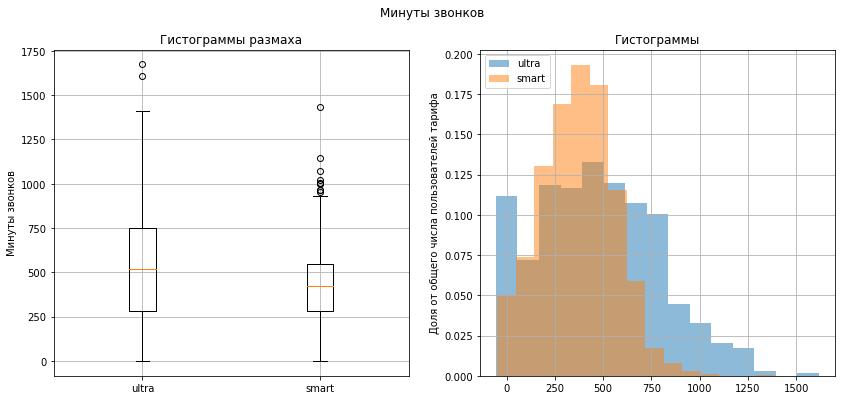

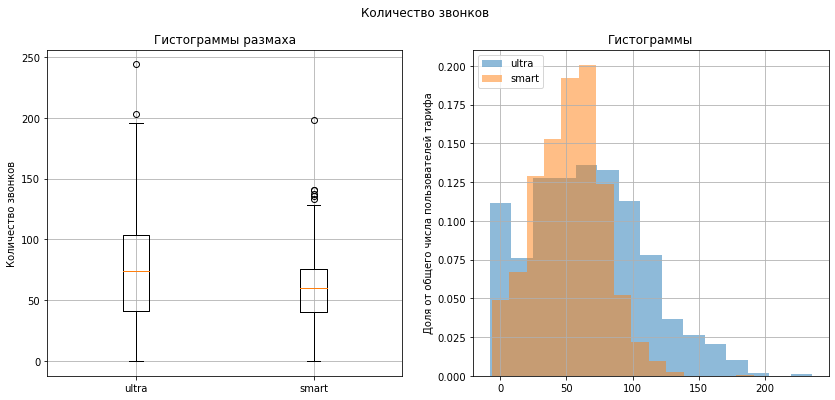

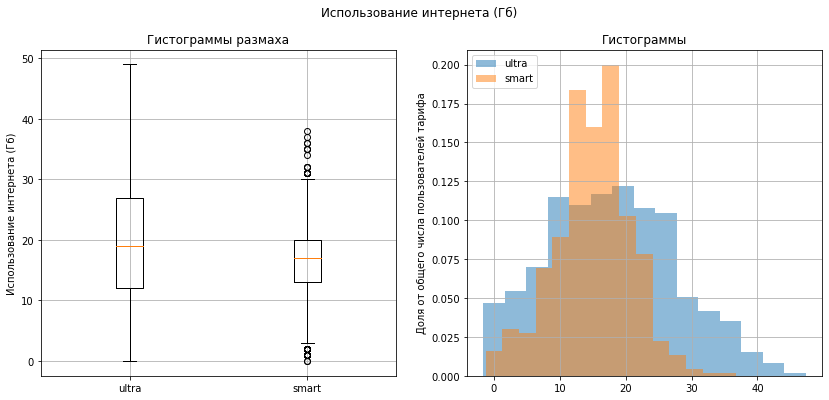

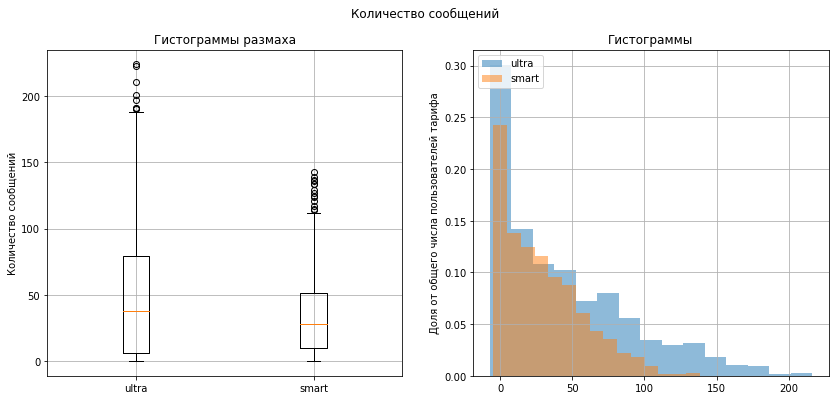

In [28]:
print('Помесячные траты пользователей в зависимости от тарифа')
for column_name, title in (
    ('calls_minutes', 'Минуты звонков'), 
    ('calls_amount', 'Количество звонков'), 
    ('gb_used', 'Использование интернета (Гб)'), 
    ('messages_amount', 'Количество сообщений')
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title)

    ax1.boxplot([ultra_users_stats[column_name], smart_users_stats[column_name]], labels = ['ultra', 'smart'])
    ax1.set_title('Гистограммы размаха')
    ax1.set_ylabel(title)
    ax1.grid()
    
    n_bins=15
    
    hist, bins = np.histogram(ultra_users_stats[column_name], bins=n_bins)
    ax2.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha = 0.5, label='ultra')
    
    hist, bins = np.histogram(smart_users_stats[column_name], bins=n_bins)
    ax2.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha = 0.5, label='smart')

    ax2.legend(loc='upper left')
    ax2.set_title('Гистограммы')
    ax2.set_ylabel('Доля от общего числа пользователей тарифа')
    ax2.grid()

Напомним: 
* тариф «Ультра» дороже и включает в себя бОльшие объемы услуг, а дополнения к этому объему стоят дешевле;
* тариф «Смарт» дешевле, включает в себя меньшие объемы услуг, а дополнения к этому объему стоят дороже.

Гистограммы количества отправленных сообщений отличаются от остальных: они сильно скошены вправо, то есть большинство пользователей обоих тарифов используют немного сообщений (при этом в тарифе «Ультра» выбросы все же распространяются дальше, в сравнении с тарифом «Смарт»). Видимо, сказывается влияние социальных сетей и интернет-мессенджеров: общение все больше переходит туда.


В целом полученные графики показывают ожидаемое: пользователи тарифа «Ультра» используют в общем бОльшие объемы услуг в сравнении с пользователями, которые используют тариф «Смарт» (медианы стоят дальше, и на гистограммах бОльшие доли расположены дальше). В данных о пользователях тарифа «Смарт» большие объемы использования услуг - это скорее редкость (выбросы, которые выходят за "усы" гистограммы размаха)

При этом у пользователей тарифа «Ультра» межквартильный размах (расстояние между первым и третьим квартилем, размер "ящика") больше, то есть средние 50% набора данных тарифа «Ультра» распределены сильнее. Пользователи могут использовать как сравнительно малые (в пределах данного тарифа), так и сравнительно большие объемы услуг (помним, что на межквартильный размах не влияют экстремальные выбросы). Это **структурные** показатели говорят о том, что данные тарифа «Смарт» более скученные (поведение пользователей этого тарифа более схоже).

Что касается распределения минут звонков и объема интернет-трафика, то соответствующие распределения для обоих тарифов напоминают нормальные (особенно если отбросить пропущенные звонки -- звонки с нулевой продолжительностью). "Колокол" у пользователей тарифа «Смарт» более высокий. Этот **алгебраический** показатель вновь подтверждает, что данные пользователей тарифа «Смарт» более скученные.

Посмотрим на статистические данные в цифрах: подсчитаем квартилили, средние и стандартные отклонения по рассматриваемым показателям для каждого тарифа 

In [29]:
print('Тариф Ультра')
ultra_users_stats[['calls_minutes', 'calls_amount', 'gb_used', 'messages_amount']].describe()

Тариф Ультра


,calls_minutes,calls_amount,gb_used,messages_amount
count,985.000000,985.000000,985.000000,985.000000
mean,526.623350,73.392893,19.494416,49.363452
std,317.606098,43.916853,9.853511,47.804457
min,0.000000,0.000000,0.000000,0.000000
25%,284.000000,41.000000,12.000000,6.000000
50%,518.000000,74.000000,19.000000,38.000000
75%,752.000000,104.000000,27.000000,79.000000
max,1673.000000,244.000000,49.000000,224.000000


In [30]:
print('Тариф Смарт')
smart_users_stats[['calls_minutes', 'calls_amount', 'gb_used', 'messages_amount']].describe()

Тариф Смарт


,calls_minutes,calls_amount,gb_used,messages_amount
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,417.934948,58.463437,16.328847,33.384029
std,190.313730,25.939858,5.747061,28.227876
min,0.000000,0.000000,0.000000,0.000000
25%,282.000000,40.000000,13.000000,10.000000
50%,422.000000,60.000000,17.000000,28.000000
75%,545.000000,76.000000,20.000000,51.000000
max,1435.000000,198.000000,38.000000,143.000000


Выводы, основанные на графиках, подтверждаются: пользователи тарифа «Смарт» (по среднему и квартилям), тратям меньшие объемы услуг по сравнению с полтзователями тарифа «Ультра», а стандартные отклонения всем рассматриваемым услугам выше у пользователей тарифа «Ультра», то есть разброс этих данных выше. 

Вспомним, что записей о пользователях, использующих тариф «Смарт», примерно в 2 раза больше, чем записей о пользователях, использующих тариф «Ультра». Более высокие показатели стандартного отклонения можно связать с этим. Однако структурные характеристики (например, межквартильный размах) приводят к таким же выводам.

Теперь проанализируем выручку компании с пользователей различных тарифов за месяц.

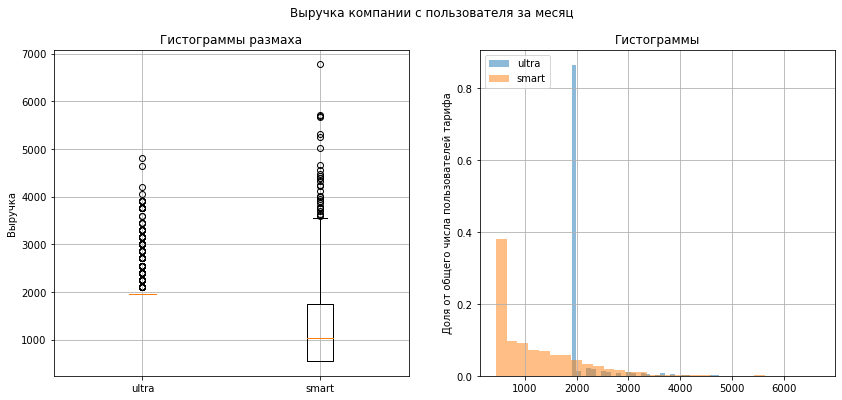

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Выручка компании с пользователя за месяц')

ax1.boxplot([ultra_users_stats['revenue'], smart_users_stats['revenue']], labels = ['ultra', 'smart'])
ax1.set_title('Гистограммы размаха')
ax1.set_ylabel('Выручка')
ax1.grid()

n_bins=30

hist, bins = np.histogram(ultra_users_stats['revenue'], bins=n_bins)
ax2.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha = 0.5, label='ultra')

hist, bins = np.histogram(smart_users_stats['revenue'], bins=n_bins)
ax2.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha = 0.5, label='smart')

ax2.legend(loc='upper left')
ax2.set_title('Гистограммы')
ax2.set_ylabel('Доля от общего числа пользователей тарифа')
ax2.grid()

По графикам видно, что выручка с клиентов, использующих тариф Ультра, в основном складывается из ежемесячной оплаты тарифа (медиана и весь ящик, то есть доход с 50% пользователей за месяцы, составляет 1950 рублей), и превышает ее довольно редко, то есть пользователи не слишком часто используют услуги сверх тарифа. 

Медиана выручки с пользователей тарифа Смарт находится на отметке около 1000 рублей. При ежемесячной плате за этот тариф в 550 рублей, это говорит о том, что пользователи данного тарифа довольно часто обращаются за дополнительными объемами услуг. Об этом же можно сказать, посмотрев на гистограмму для тарифа Смарт, которая сильно смещена вправо. По диаграмме также можно оценить долю пользователей, которые обращаются за дполнительными объемами услуг: около 40% всех месячных выручек находятся на уровне 550 рублей (ежемесячная плата за этот тариф), а остальные - правее. То есть около 60% пользователей обращаются за дполнительными объемами услуг.


In [32]:
print('Статистические данные о выручке')
print(f"Тариф Ультра.  Среднее: {round(ultra_users_stats['revenue'].mean())}, медиана: {round(ultra_users_stats['revenue'].median())}, дисперсия: {round(np.var(ultra_users_stats['revenue'], ddof=1))}")
print(f"Тариф Смарт. Среднее: {round(smart_users_stats['revenue'].mean())}, медиана: {round(smart_users_stats['revenue'].median())}, дисперсия: {round(np.var(smart_users_stats['revenue'], ddof=1))}")


Статистические данные о выручке
Тариф Ультра.  Среднее: 2070, медиана: 1950, дисперсия: 141517
Тариф Смарт. Среднее: 1290, медиана: 1023, дисперсия: 669786


На данной выборке средняя и медианная выручка по тарифу Ультра выше (практически в 2 раза), чем по тарифу Смарт, поэтому есть основание предположить, что такой же результат будет верен и для соответствующих генеральных совокупностей. 

При этом дисперсия выручки, то ее есть разброс значений, по тарифу Ультра выше примерно в 5 раз. Это объяснимо тем, что и разбросы значений по объемам используемых услуг пользователями этого тарифа выше. Возможно, компании следует следует обратить на активных пользователей тарифа Ультра дополнительное внимание.

# 5. Проверка гипотез <a class="anchor" id="b6"></a>

### 1. Cредние выручки пользователей тарифов «Ультра» и «Смарт» различаются.

Размеры выборок достаточно большие (всего 3214 записей, из них 31% -- о тарифе Ультра, 69% -- о тарифе Смарт), поэтому, согласно центрально предельной теореме, можно считать, что выборочные средние нормально распределены. Генеральные совокупности (выручки с пользователей различных тарифов) независимы. Таким образом, для проверки гипотезы применИм статистический тест с использованием t-распределения Стьюдента (при этом необходимо учитывать равенство или различие дисперсий).

Н0 всегда формулируется так, чтобы использовать знак равенства:

**Н0="средние выручки пользователей тарифов «Ультра» и «Смарт» равны"**.

Так как задача - выяснить, какой тариф приносит больше денег, и есть основания предполагать, что средняя выручка по тарифу Ультра выше, чем по тарифу Смарт, то будем использовать следующую одностороннюю альтернативную гипотезу: 

**Н1="Средняя выручка пользователей тарифа «Ультра» больше, чем пользователей тарифа «Смарт»"**.


Так как выборки независимые, то для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам применим метод `scipy.stats.ttest_ind(array1, array2, equal_var)`. Выборки разного размера, и дисперсия выручки по тарифу Ультра в несколько раз больше, чем дисперсия выручки по тарифу Смарт, поэтому в параметре equal_var укажем False (чтобы дисперсии считались разными и тест не объединял обе выборки в одну для более точной оценки дисперсии).

Метод возвращает два числа: cтатистику разности и ее уровень значимости p-value (вероятность получить наблюдаемый или еще более далекий от предполагаемого результат при условии, что нулевая гипотеза верна). p-value возвращается двусторонним, а наша альтернативная гипотеза односторонняя, поэтому полученный p-value будем делить на 2, а также использовать дополнительное сравнение при принятии решения о необходимости отвержения нулевой гипотезы.


In [33]:
import scipy.stats as st

# Установим пороговое значение (критический уровень статистической значимости) alpha - 5%
alpha = 0.05 

In [34]:
res = st.ttest_ind(ultra_users_stats['revenue'], smart_users_stats['revenue'], equal_var=False)
print(f'p-value: {res.pvalue / 2}')

if res.pvalue / 2 < alpha and ultra_users_stats['revenue'].mean() > smart_users_stats['revenue'].mean():
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 2.1303156965538042e-250
Отвергаем нулевую гипотезу


Полученное значение pvalue говорит о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, и такое различие практически невозможно получить случайно (вероятность стремится к 0). Таким образом, нельзя делать вывод о равенстве средней прибыли. Также выполнено условие: среднее по выручке пользователей тарифа «Ультра» больше чем пользователей тарифа «Смарт». 

Таким образом, нулевую гипотезу отвергаем: нельзя сказать, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается, а альтернативную гипотезу оставляем: вполне возможно, что средняя выручка пользователей тарифа «Ультра» больше чем пользователей тарифа Смарт.

### 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Разделим выборку на соответсвующие части

In [35]:
useres_stats_moscow = users_stats[users_stats['city'] == 'Москва']
useres_stats_other = users_stats[users_stats['city'] != 'Москва']

print('Количество записей')
print('Всего:', len(users_stats))
print(f'О пользователях из Москвы: {round(len(useres_stats_moscow) * 100 / len(users_stats))}%')
print(f'О пользователях из других регионов: {round(len(useres_stats_other) * 100 / len(users_stats))}%')

Количество записей
Всего: 3214
О пользователях из Москвы: 19%
О пользователях из других регионов: 81%


Применим все те же рассуждения за исключением того, что альтернативную гипотезу сформулируем односторонней (в учебных целях -- для разнообразия, а также исходя из того, что не проводился предварительный анализ для такой стратификации выборки, и нет достаточного обоснования, чтобы предположить, что средняя выручка одной из групп больше другой.

Здесь также укажем, что дисперсии нельзя считать равными, так как размер выборки о пользователях из Москвы в 4 раза меньше, чем размер выборки о пользователях из других регионов (проверено и при equal_var=True, результат теста тот же, различия p-valuе в тысячных долях)

**Н0="средние выручки пользователей из Москвы и пользователей из других регионов равны"**.

**Н1="средние выручки пользователей из Москвы и пользователей из других регионов не равны"**.

In [36]:
res = st.ttest_ind(useres_stats_moscow['revenue'], useres_stats_other['revenue'], equal_var=False)
print(f'p-value: {res.pvalue}')

if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что с вероятностью в 5.26% полученное различие средней выручки пользователей из Москвы и из других регионов случайно. Это достаточная вероятность, чтобы оставить нулевую гипотезу. Таким образом, гипотеза о том, что средние выручки пользователей из Москвы и пользователей из других регионов равны, не отвергается.

# Вывод <a class="anchor" id="b7"></a>

Был проведен предварительный анализ ежемесячной выручки и поведения клиентов на небольшой выборке клиентов.

**В результате анализа** выяснилось, что в этой выборке в среднем пользователи тарифа Смарт в месяц:
* тратят 417 минут звонков (меньше включенного количества), 
* отправляют 33 сообщения (меньше включенного количества), 
* используют 16 Гб интернета (примерно равно включенным в пакет), 

а пользователи тарифа Ультра - 

* 527 минут звонков (в 6 раз меньше включенного количества), 
* 49 сообщений (в 20 раз меньше включенного количества),
* 19 Гб интернета (в 1.5 раза меньше включенного количества). 



Также в ходе анализа стало известно, что средняя месячная выручка с пользователей тарифа Ультра состваляет 2070 рублей, а  с пользователей тарифа Смарт - 1290 рублей.

Однако по одному среднему из выборки нельзя делать выводов о поведении всех клиентов, ведь  поведение клиента и выручка значительно меняются от пользователя к пользователю. 

В целом, разброс значений различных данных у пользоваетелей тарифа Смарт меньше, чем у пользователей тарифа Ультра. Пользователей тарифа Ультра в выборке примерно в 2 раза меньше, чем пользователей тарифа Смарт.





**При проверке гипотез** были оставлены (не удалось опровергнуть) две гипотезы.

1. Средняя выручка пользователей тарифа «Ультра» больше, чем пользователей тарифа «Смарт».

2. Средние выручки пользователей из Москвы и пользователей из других регионов равны.


Таким образом, коммерческому департаменту для увеличения прибыли, возможно, следует обратить внимание на пользователей тарифа Ультра (особенно тех, кто значительно превышает предложенный объем услуг). При этом делать между клиентами из Москвы и клиентами из других регионов, возможно, нет необходимости.

Черновое: Как и ожидалось, в этой выборке в среднем пользователи тарифа смарт тратят меньше минут разговора, сообщений и интернет-трафика в месяц, чем пользователи тарифа ультра. Практически все распределения скошены влево, а значит есть пользователи, которым нужно значительно больше перечисленных услуг, чем средним. Возможно, стоит разработать для таких клиентов особый подход.

```
# users_stats['tariff_num'] = (users_stats['tariff'] == 'ultra').astype(int)

# plt.rcParams.update({'font.size': 15})
# print('Матрица рассеяния по статистическим данным использованных услуг')
# pd.plotting.scatter_matrix(users_stats.drop(['user_id', 'calls_amount'], axis=1), alpha=0.2, figsize=(20, 10))
# plt.show()
# plt.rcParams.update({'font.size': 12})
```
Можно заметить, что к концу года объем использования услуг несколько увеличивается. Также видно положительную корреляцию между количеством и суммарной продолжительностью звонков (что логично). Распределения объемов использования звонков и интернета похожи на нормальные, со смещением вправо, а вот с сообщениями ситуация иная: большинство пользователей используют мало сообщений.